# Capstone for Coursera's IBM professional certificate in data science
### Week 3 Project
The goal of this project is to use k-means clustering to define neighborhoods in Toronto

In [4]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

#mapping tools 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Scrape Wikipedia with BeautifulSoup

In [5]:
# read csv file
geo = pd.read_csv('https://cocl.us/Geospatial_data') 
# examine the shape of original input data
print(geo.shape)
geo.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# create an object with raw data from website
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

In [7]:
# create an object with the data from the website
bs = BeautifulSoup(website_url)

In [8]:
# search for table
tbl = bs.find('table',{'class':'wikitable sortable'})
#tbl

In [9]:
# clean data
rows = []
for row in tbl.find_all("tr"):
    cols = row.find_all("td")
    cols = [idx.text.strip() for idx in cols]
    rows.append(cols)

rows[0:5]

[[],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

In [10]:
# remove empty indices
rows.remove([])

In [11]:
rows[0:5]

[['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront']]

## Part 1: Build initial dataframe

In [12]:
#create initial pd DataFrame
df = pd.DataFrame(rows)
df = df.rename(columns={0:"Postcode",1:"Borough",2:"Neighborhood"})
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [13]:
df[df['Borough']!='Not assigned'].head()

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [14]:
#drop rows where 'Bourough' = 'Not assigned'
df = df[df['Borough']!='Not assigned'].reset_index(drop=True)
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [15]:
df['Neighborhood'] = np.where(
    df['Neighborhood']=='Not assigned',
    df['Borough'],
    df['Neighborhood']
)
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [110]:
df = (df.groupby(['Postcode','Borough'])['Neighborhood']
       .apply(lambda x: ','.join(set(x.dropna())))
       .reset_index())

df = pd.DataFrame(df)
df.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"West Hill,Morningside,Guildwood"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [112]:
df.shape

(103, 3)

**Part 1 answer: The final shape is (103, 3)**
***


***
# Part 2 - Add Coordinates

In [114]:
df = df.join(geo.set_index('Postal Code'), how='outer', on='Postcode')
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


***


***
# Part 3 - Map & Cluster

In [18]:
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [19]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.653963, -79.387207.


In [115]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{},{}'.format(neighborhood,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto) 

map_toronto

**Setup FourSquare API**

In [25]:
# from https://foursquare.com/developers/apps
CLIENT_ID = 'your_id_here' # my Foursquare ID
CLIENT_SECRET = 'your_secret_here' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [120]:
#define objects for row 4
neighborhood_latitude = df.loc[4, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[4, 'Longitude'] # neighborhood longitude value
neighborhood = df.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of ', neighborhood, 'are {}, {}.'
      .format(neighborhood_latitude, 
              neighborhood_longitude))

Latitude and longitude values of  Cedarbrae are 43.773136, -79.23947609999999.


In [121]:
#step 1 - create the correct GET request URL
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

**Pull Data**

In [122]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cbb361a4c1f672685b305d9'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Woburn',
  'headerFullLocation': 'Woburn, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 43.7776360045, 'lng': -79.2332557734104},
   'sw': {'lat': 43.7686359955, 'lng': -79.24569642658957}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b1711a6f964a520cbc123e3',
       'name': 'Federick Restaurant',
       'location': {'address': '1920 Ellesmere Rd',
        'crossStreet': 'at Bellamy Rd. N',
        'lat': 43.77469659057996,
        'lng': -79.24114242818267,
        'labeledLatLngs': [{'label': 'dis

**Identify Venues & Locations**

In [123]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [124]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Federick Restaurant,Hakka Restaurant,43.774697,-79.241142
1,Drupati's Roti & Doubles,Caribbean Restaurant,43.775222,-79.241678
2,Thai One On,Thai Restaurant,43.774468,-79.241268
3,Centennial Recreation Centre,Athletics & Sports,43.774593,-79.236500
4,TD Canada Trust,Bank,43.774952,-79.241343


In [125]:
map_venues = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=17)

# add markers to map
for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{},{}'.format(categories,name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_venues) 
    
map_venues

# Clustering

**Aggregate Data**

In [126]:
# create a function to get all venues for each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [129]:
#run function for all toronto neighborhoods and create df 'toronto_venues'
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude']
                                 )

In [130]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern,Rouge",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern,Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"West Hill,Morningside,Guildwood",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


In [131]:
print(toronto_venues.groupby('Neighborhood').count().shape)
toronto_venues.groupby('Neighborhood').count().head()

(100, 6)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,Richmond,King",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
Bayview Village,4,4,4,4,4,4
Berczy Park,57,57,57,57,57,57
"Brockton,Parkdale Village,Exhibition Place",22,22,22,22,22,22


**Analyze Neighborhoods * Venues**

In [132]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(100, 280)


,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,Richmond,King",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.010000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,Bayview Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.017544,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,"Brockton,Parkdale Village,Exhibition Place",0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [133]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [171]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,Richmond,King",Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Restaurant,Asian Restaurant,Sushi Restaurant,Bakery,Burger Joint
1,Agincourt,Breakfast Spot,Lounge,Clothing Store,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
2,Bayview Village,Bank,Chinese Restaurant,Café,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store
3,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Farmers Market,Cheese Shop,Bakery,Pub,Steakhouse,Café,Seafood Restaurant
4,"Brockton,Parkdale Village,Exhibition Place",Coffee Shop,Breakfast Spot,Café,Yoga Studio,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Pet Store,Bar


**Cluster Neighborhoods**

In [172]:
toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhood'])

Text(0.5, 1.0, 'The Elbow Method to find the optimal k')

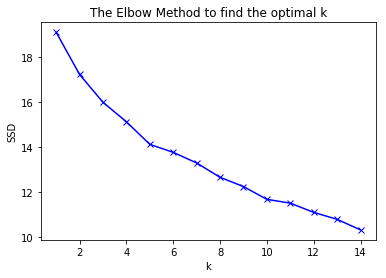

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

# k means determine k
ssd = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, 
                    init='random',
                    n_init=100,
                    max_iter=1000,
                    random_state=409
                   )
    kmeans.fit(toronto_grouped_clustering)
    ssd.append(kmeans.inertia_)

# Plot the elbow
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('SSD')
plt.title('The Elbow Method to find the optimal k')

In [174]:
# optimal k from above is 5
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhood'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int32)

In [175]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Adelaide,Richmond,King",Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Restaurant,Asian Restaurant,Sushi Restaurant,Bakery,Burger Joint
1,1,Agincourt,Breakfast Spot,Lounge,Clothing Store,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
2,1,Bayview Village,Bank,Chinese Restaurant,Café,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store
3,1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Farmers Market,Cheese Shop,Bakery,Pub,Steakhouse,Café,Seafood Restaurant
4,1,"Brockton,Parkdale Village,Exhibition Place",Coffee Shop,Breakfast Spot,Café,Yoga Studio,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Pet Store,Bar


In [176]:
toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), how='inner', on='Neighborhood')

toronto_merged # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353,1,Print Shop,Fast Food Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1,Bar,Construction & Landscaping,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
2,M1E,Scarborough,"West Hill,Morningside,Guildwood",43.763573,-79.188711,1,Electronics Store,Spa,Rental Car Location,Intersection,Mexican Restaurant,Breakfast Spot,Medical Center,Pizza Place,Doner Restaurant,Dog Run
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Hakka Restaurant,Fried Chicken Joint,Thai Restaurant,Caribbean Restaurant,Bakery,Bank,Athletics & Sports,Drugstore,Donut Shop,Doner Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0,Playground,Jewelry Store,Women's Store,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
6,M1K,Scarborough,"East Birchmount Park,Kennedy Park,Ionview",43.727929,-79.262029,1,Department Store,Coffee Shop,Discount Store,Hobby Shop,Convenience Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar
7,M1L,Scarborough,"Golden Mile,Clairlea,Oakridge",43.711112,-79.284577,1,Bakery,Bus Line,Park,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Soccer Field,Construction & Landscaping,Convenience Store
8,M1M,Scarborough,"Scarborough Village West,Cliffcrest,Cliffside",43.716316,-79.239476,1,Movie Theater,Motel,American Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
9,M1N,Scarborough,"Cliffside West,Birch Cliff",43.692657,-79.264848,1,Café,College Stadium,Skating Rink,General Entertainment,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


In [177]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Interestingly, we have on very large cluster, one medium cluster, and a bunch of small clusters

## Define Clusters
* Cluster 0 is defined by parks and playgrounds
* Cluster 1 is defined by places to eat
* Cluster 2 has womens shopping areas
* Cluster 3 has banks
* Cluster 4 has baseball 

In [178]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,0,Playground,Jewelry Store,Women's Store,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
14,Scarborough,0,Park,Playground,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
25,North York,0,Park,Fast Food Restaurant,Food & Drink Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
30,North York,0,Park,Other Repair Shop,Bus Stop,Airport,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
31,North York,0,Grocery Store,Bank,Moving Target,Park,Golf Course,Curling Ice,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
40,East York,0,Park,Convenience Store,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
44,Central Toronto,0,Park,Bus Line,Swim School,Ethiopian Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
48,Central Toronto,0,Gym,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant
50,Downtown Toronto,0,Park,Trail,Playground,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
64,Central Toronto,0,Jewelry Store,Trail,Park,Sushi Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar


In [179]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1,Print Shop,Fast Food Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
1,Scarborough,1,Bar,Construction & Landscaping,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
2,Scarborough,1,Electronics Store,Spa,Rental Car Location,Intersection,Mexican Restaurant,Breakfast Spot,Medical Center,Pizza Place,Doner Restaurant,Dog Run
3,Scarborough,1,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
4,Scarborough,1,Hakka Restaurant,Fried Chicken Joint,Thai Restaurant,Caribbean Restaurant,Bakery,Bank,Athletics & Sports,Drugstore,Donut Shop,Doner Restaurant
6,Scarborough,1,Department Store,Coffee Shop,Discount Store,Hobby Shop,Convenience Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar
7,Scarborough,1,Bakery,Bus Line,Park,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Soccer Field,Construction & Landscaping,Convenience Store
8,Scarborough,1,Movie Theater,Motel,American Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
9,Scarborough,1,Café,College Stadium,Skating Rink,General Entertainment,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
10,Scarborough,1,Indian Restaurant,Vietnamese Restaurant,Furniture / Home Store,Thrift / Vintage Store,Latin American Restaurant,Chinese Restaurant,Pet Store,Drugstore,Dumpling Restaurant,Donut Shop


In [180]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,2,Garden,Women's Store,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run


In [181]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,North York,3,Park,Bank,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega,Doner Restaurant
94,Etobicoke,3,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Women's Store,Deli / Bodega


In [182]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,North York,4,Food Truck,Baseball Field,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant
97,North York,4,Baseball Field,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop
